# IBM Data Science Capstone Project : The Battle of Neighborhood

## **Best Location To Open Indonesian Restaurant**

By Yosia Azarya

![alt text](https://d22ir9aoo7cbf6.cloudfront.net/wp-content/uploads/sites/3/2017/03/KAUM.jpg)




With this notebook, I created a program to find best location to build an Indonesian Restaurant.

### 1. Import libraries

In [3]:
import requests
import pandas as pd
import numpy as np
from numpy import *
import operator
from numpy.linalg import *
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print("Library import success!")

Library import success!


### 2. Scrap data from Wikipedia into Dataframe

First, download the html data from wikipedia.

In [4]:
url  = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url)
if page.status_code == 200:
    print('Page download successful')
else:
    print('Page download error. Error code: {}'.format(page.status_code))

Page download successful


After that, convert the html data into dataframe with pandas.

In [5]:
df_html = pd.read_html(url, header=0, na_values = ['Not assigned'])[0]
df_html.head()

,Postal Code,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop rows with the "NaN" value of Borough.

In [6]:
df_html.dropna(subset=['Borough'], inplace=True)
df_html.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Check if there any "NaN" value of Neighborhood.

In [7]:
n_empty_neighborhood = df_html[df_html['Neighborhood'].isna()].shape[0]
print('Number of rows on which Neighborhood column is empty: {}'.format(n_empty_neighborhood))

Number of rows on which Neighborhood column is empty: 0


Group the dataframe with rows with the same Borough.

In [8]:
df_postcodes = df_html.groupby(['Postal Code','Borough']).Neighborhood.agg([('Neighbourhood', ', '.join)])
df_postcodes.reset_index(inplace=True)
df_postcodes.head(5)

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Check the shape of cleaned dataframe.

In [10]:
df_postcodes.shape

(103, 3)

Save the cleaned dataframe into csv file.

In [11]:
df_postcodes.to_csv("torontodata.csv")

### 3. Combine cleaned dataframe with geospacial data

Download the geospacial data with the link given and convert them into dataframe.

In [12]:
url_csv = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(url_csv)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Call the cleaned dataframe with pandas.

In [13]:
df_neighborhoods = pd.read_csv("torontodata.csv",index_col=[0])
df_neighborhoods.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Merge both datasets.

In [14]:
df_neighborhoods_coordinates = pd.merge(df_neighborhoods, df_coordinates, on='Postal Code')
df_neighborhoods_coordinates.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Check whether both datasets is successfully merged.

In [15]:
df_neighborhoods_coordinates[(df_neighborhoods_coordinates['Postal Code']=='M5G') |
                             (df_neighborhoods_coordinates['Postal Code']=='M2H') ]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
17,M2H,North York,Hillcrest Village,43.803762,-79.363452
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [16]:
dfa = df_neighborhoods_coordinates
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(dfa['Borough'].unique()),
        dfa.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [17]:
dfa.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

Select rows with Borough contains "Toronto".

In [18]:
df_toronto = dfa[dfa['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True)
df_toronto.drop('index', axis=1, inplace=True)
df_toronto.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
34,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
35,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325
36,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
37,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


In [19]:
print(df_toronto.groupby('Borough').count()['Neighbourhood'])

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
West Toronto         6
Name: Neighbourhood, dtype: int64


In [20]:
boroughs = df_toronto['Borough'].unique().tolist()

4. Show the map of Toronto

In [21]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.66713498717948, -79.38987324871795


In [22]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [23]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### 5. Use the FourSquare API to explore the neighborhood

Define all the credential needed to make call on FourSquare API.

In [24]:
CLIENT_ID = #inputclientid
CLIENT_SECRET = #inputclientsecret
VERSION = #YYYYMMDD
LIMIT = 100
radius = 500

Get the top 100 venues within 500m radius

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [27]:
toronto_venues.to_csv("APIfq1.csv")

In [28]:
df_hasilfq = pd.read_csv("APIfq1.csv",index_col=0)
df_hasilfq

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant
...,...,...,...,...,...,...,...
1616,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1617,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1618,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,The Ten Spot,43.664815,-79.324213,Spa
1619,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher


In [29]:
df_hasilfq.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,17,17,17,17,17,17
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [30]:
array1 = df_hasilfq['Venue Category'].unique()

In [31]:
array1[0]

'Trail'

Select only venues category with "Restaurant" in it.

In [32]:
kumpulan_restaurant = []
for i in range(len(array1)):
  # print(i)
  if "Restaurant" in array1[i]:
    kumpulan_restaurant.append(array1[i])

print(kumpulan_restaurant)

['Asian Restaurant', 'Greek Restaurant', 'Italian Restaurant', 'Restaurant', 'Caribbean Restaurant', 'Japanese Restaurant', 'Indian Restaurant', 'American Restaurant', 'Fast Food Restaurant', 'Sushi Restaurant', 'Thai Restaurant', 'Seafood Restaurant', 'Comfort Food Restaurant', 'Middle Eastern Restaurant', 'Latin American Restaurant', 'Chinese Restaurant', 'Mexican Restaurant', 'Vietnamese Restaurant', 'Taiwanese Restaurant', 'Theme Restaurant', 'Ramen Restaurant', 'Mediterranean Restaurant', 'Afghan Restaurant', 'French Restaurant', 'Modern European Restaurant', 'New American Restaurant', 'Ethiopian Restaurant', 'Vegetarian / Vegan Restaurant', 'German Restaurant', 'Moroccan Restaurant', 'Belgian Restaurant', 'Eastern European Restaurant', 'Falafel Restaurant', 'Korean Restaurant', 'Colombian Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Dumpling Restaurant', 'Doner Restaurant', 'Filipino Restaurant', 'Dim Sum Restaurant', 'Molecular Gastronomy Restaurant', 'Cuban R

Analyze each neighborhood

In [33]:
to_onehot = pd.get_dummies(df_hasilfq[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = df_hasilfq['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1621, 239)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,...,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(39, 239)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,...,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.0000,0.017857,0.000000,0.017857,0.035714,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.000000,0.017857,0.000000,0.0000,0.000000,0.0000,0.00000,0.017857,0.000000,0.000000,...,0.000000,0.035714,0.000000,0.017857,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.0000,0.000000,0.000,0.017857,0.000000,0.0000,0.017857,0.00,0.00,0.017857,0.000000,0.00,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.083333,0.000000,0.041667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.00000,0.083333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.0000,0.041667,0.000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.041667
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.00000,0.000000,0.062500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0625,0.00,0.000000,0.000000,0.000000,0.000000,0.062500,0.00000,0.00,0.0000,0.000000,0.000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.0625,0.00000,0.000000,0.000000,0.000000,...,0.062500,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.0000,0.000000,0.000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.015625,0.000000,0.000000,0.000000,0.00

Create a dataframe of neighborhoods and all restaurant.

In [35]:
to_asian = to_grouped[["Neighborhoods"]+kumpulan_restaurant]
to_asian.head()


,Neighborhoods,Asian Restaurant,Greek Restaurant,Italian Restaurant,Restaurant,Caribbean Restaurant,Japanese Restaurant,Indian Restaurant,American Restaurant,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,Latin American Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Taiwanese Restaurant,Theme Restaurant,Ramen Restaurant,Mediterranean Restaurant,Afghan Restaurant,French Restaurant,Modern European Restaurant,New American Restaurant,Ethiopian Restaurant,Vegetarian / Vegan Restaurant,German Restaurant,Moroccan Restaurant,Belgian Restaurant,Eastern European Restaurant,Falafel Restaurant,Korean Restaurant,Colombian Restaurant,Brazilian Restaurant,Gluten-free Restaurant,Dumpling Restaurant,Doner Restaurant,Filipino Restaurant,Dim Sum Restaurant,Molecular Gastronomy Restaurant,Cuban Restaurant,Tapas Restaurant,Cajun / Creole Restaurant
0,Berczy Park,0.0,0.017857,0.000000,0.035714,0.0,0.017857,0.000000,0.0,0.0000,0.017857,0.017857,0.035714,0.017857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.017857,0.000000,0.0,0.0,0.017857,0.0,0.0,0.0,0.017857,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.041667,0.041667,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Business reply mail Processing Centre, South C...",0.0,0.000000,0.000000,0.062500,0.0,0.000000,0.000000,0.0,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Central Bay Street,0.0,0.000000,0.062500,0.000000,0.0,0.046875,0.015625,0.0,0.0000,0.015625,0.031250,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.015625,0.0,0.0,0.015625,0.0,0.0,0.0,0.000000,0.015625,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6. Eliminate the neighborhood with no restaurant

Create a dataframe of neighborhoods and sum of restaurant.

In [36]:
to_filtering = to_grouped[["Neighborhoods"]]
to_filtering["Sum of Restaurant"] = to_asian[kumpulan_restaurant].sum(axis=1)
to_filtering.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhoods,Sum of Restaurant
0,Berczy Park,0.214286
1,"Brockton, Parkdale Village, Exhibition Place",0.083333
2,"Business reply mail Processing Centre, South C...",0.125000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.281250


Check the shape of the dataframe.

In [37]:
to_filtering.shape

(39, 2)

Cut the rows of neighborhoods with no restaurant.

In [38]:
resto = to_filtering["Sum of Restaurant"].values
resto

array([0.21428571, 0.08333333, 0.125     , 0.        , 0.28125   ,
       0.11764706, 0.29333333, 0.3       , 0.27272727, 0.        ,
       0.0625    , 0.3       , 0.16666667, 0.22      , 0.12      ,
       0.32      , 0.20833333, 0.30645161, 0.        , 0.36363636,
       0.33333333, 0.2       , 0.26666667, 0.11764706, 0.09090909,
       0.23913043, 0.        , 0.        , 0.26315789, 0.26923077,
       0.23913043, 0.20833333, 0.2       , 0.25      , 0.14285714,
       0.2       , 0.39534884, 0.26      , 0.29411765])

In [39]:
buangindex = []
for i in range(len(resto)):
  if resto[i] == 0:
    buangindex.append(i)

In [40]:
buangindex

[3, 9, 18, 26, 27]

In [41]:
to_filtering = to_filtering.drop(to_filtering.index[buangindex])
to_filtering.shape

(34, 2)

change the column name

In [42]:
to_filtering.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)

In [43]:
to_filtering = to_filtering.join(df_hasilfq.set_index("Neighborhood"), on="Neighborhood")



In [44]:
to_filtering.head()

,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.214286,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.214286,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.214286,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.214286,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.214286,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [45]:
to_clustering = to_filtering[["Neighborhood Latitude","Neighborhood Longitude"]]

In [46]:
to_clustering.head()

,Neighborhood Latitude,Neighborhood Longitude
0,43.644771,-79.373306
0,43.644771,-79.373306
0,43.644771,-79.373306
0,43.644771,-79.373306
0,43.644771,-79.373306


### 7. Kmeans clustering

Do simulation to know best value for K

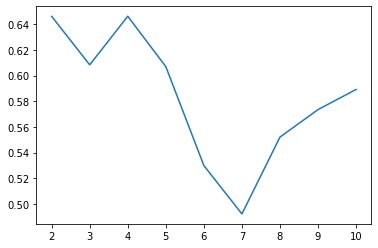

In [47]:
sil = []
kmax = 10
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeansx = KMeans(n_clusters = k).fit(to_clustering)
  labels = kmeansx.labels_
  sil.append(silhouette_score(to_clustering, labels, metric = 'euclidean'))

plt.plot (list(range(2,11)),sil)

Do the Kmeans culstering with the best value of K

In [48]:
# set number of clusters
K = 4

# run k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Add cluster label to dataframe.

In [49]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_filtering.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_
to_merged.tail()

,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
38,"University of Toronto, Harbord",0.294118,43.662696,-79.400049,Magic Noodle,43.662728,-79.403602,Noodle House,0
38,"University of Toronto, Harbord",0.294118,43.662696,-79.400049,DT Bistro,43.662375,-79.405734,Café,0
38,"University of Toronto, Harbord",0.294118,43.662696,-79.400049,Comfort Zone,43.658397,-79.400274,Nightclub,0
38,"University of Toronto, Harbord",0.294118,43.662696,-79.400049,The Beer Store,43.665385,-79.403477,Beer Store,0
38,"University of Toronto, Harbord",0.294118,43.662696,-79.400049,East of Brunswick,43.665609,-79.403324,Pub,0


Change the position of "Cluster Label" column

In [50]:
cols = to_merged.columns.tolist()
cols = cols[-1:] + cols[:-1]
to_merged = to_merged[cols]
to_merged.head()

,Cluster Labels,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Berczy Park,0.214286,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,0,Berczy Park,0.214286,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,0,Berczy Park,0.214286,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,0,Berczy Park,0.214286,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,0,Berczy Park,0.214286,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


Sort the values by "Cluster Label"

In [51]:
# sort the results by Cluster Labels
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

,Cluster Labels,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,Shoppers Drug Mart,43.674959,-79.407986,Pharmacy
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,Subway,43.675650,-79.410255,Sandwich Place
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,Tim Hortons,43.675800,-79.403532,Coffee Shop
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,LCBO,43.675344,-79.405327,Liquor Store
8,3,Davisville,0.272727,43.704324,-79.388790,Meow Cat Cafe,43.702927,-79.388190,Café


### 8. Clustering visualization

In [52]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(K)
ys = [i+x+(i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 9. Examine Clusters

Cluster 0

In [53]:
to_merged.loc[to_merged['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Berczy Park,0.214286,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
25,0,"Richmond, Adelaide, King",0.239130,43.650571,-79.384568,Lobby Lounge at the Shangri-La Toronto,43.649155,-79.386546,Lounge
25,0,"Richmond, Adelaide, King",0.239130,43.650571,-79.384568,Toronto PATH System,43.649903,-79.383053,General Travel
25,0,"Richmond, Adelaide, King",0.239130,43.650571,-79.384568,Friendly Stranger - Cannabis Culture Shop,43.650387,-79.388523,Smoke Shop
25,0,"Richmond, Adelaide, King",0.239130,43.650571,-79.384568,JaBistro,43.649687,-79.388090,Sushi Restaurant
...,...,...,...,...,...,...,...,...,...
11,0,"First Canadian Place, Underground city",0.300000,43.648429,-79.382280,Starbucks,43.646799,-79.380690,Coffee Shop
11,0,"First Canadian Place, Underground city",0.300000,43.648429,-79.382280,Noodle King,43.651706,-79.383046,Asian Restaurant
11,0,"First Canadian Place, Underground city",0.300000,43.648429,-79.382280,Hudson's Bay,43.652040,-79.380391,Department Store
11,0,"First Canadian Place, Underground city",0.300000,43.648429,-79.382280,Freshii,43.649273,-79.383748,Salad Place


Cluster 1

In [54]:
to_merged.loc[to_merged['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
15,1,"High Park, The Junction South",0.320000,43.661608,-79.464763,Chica’s Nashville Hot Chicken,43.665295,-79.464888,Fried Chicken Joint
15,1,"High Park, The Junction South",0.320000,43.661608,-79.464763,Pascal's Baguette & Bagels,43.665426,-79.466176,Bakery
15,1,"High Park, The Junction South",0.320000,43.661608,-79.464763,Junction Grill,43.665210,-79.468461,Diner
15,1,"High Park, The Junction South",0.320000,43.661608,-79.464763,ROUX,43.665418,-79.462392,Cajun / Creole Restaurant
15,1,"High Park, The Junction South",0.320000,43.661608,-79.464763,Cool Hand of a Girl,43.665410,-79.462822,Café
...,...,...,...,...,...,...,...,...,...
19,1,"Little Portugal, Trinity",0.363636,43.647927,-79.419750,Founder Restaurant & Bar,43.649478,-79.425352,Restaurant
19,1,"Little Portugal, Trinity",0.363636,43.647927,-79.419750,Frankie's Bar & Cafe,43.644290,-79.418481,Diner
28,1,"Runnymede, Swansea",0.263158,43.651571,-79.484450,Goodfellas Wood Oven Pizza,43.648224,-79.486356,Italian Restaurant
19,1,"Little Portugal, Trinity",0.363636,43.647927,-79.419750,Carmen,43.644829,-79.415872,Tapas Restaurant


Cluster 2

In [55]:
to_merged.loc[to_merged['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
36,2,"The Danforth West, Riverdale",0.395349,43.679557,-79.352188,Carrot Commons,43.677485,-79.353076,Restaurant
36,2,"The Danforth West, Riverdale",0.395349,43.679557,-79.352188,Dough Bakeshop,43.676643,-79.356846,Bakery
36,2,"The Danforth West, Riverdale",0.395349,43.679557,-79.352188,IL FORNELLO on Danforth,43.678604,-79.346904,Italian Restaurant
36,2,"The Danforth West, Riverdale",0.395349,43.679557,-79.352188,Simone's Caribbean Restaurant,43.678655,-79.346582,Caribbean Restaurant
36,2,"The Danforth West, Riverdale",0.395349,43.679557,-79.352188,Athen's Pastries,43.678166,-79.348927,Greek Restaurant
...,...,...,...,...,...,...,...,...,...
35,2,The Beaches,0.200000,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
35,2,The Beaches,0.200000,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
32,2,Studio District,0.200000,43.659526,-79.340923,Jimmie Simpson Park,43.659230,-79.345063,Park
32,2,Studio District,0.200000,43.659526,-79.340923,Saulter Street Brewery,43.658412,-79.346392,Brewery


Cluster 3

In [56]:
to_merged.loc[to_merged['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,Sum of Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8,3,Davisville,0.272727,43.704324,-79.388790,Pizza Pizza,43.706138,-79.389292,Pizza Place
21,3,"North Toronto West, Lawrence Park",0.200000,43.715383,-79.405678,Milkcow,43.715907,-79.400125,Ice Cream Shop
21,3,"North Toronto West, Lawrence Park",0.200000,43.715383,-79.405678,Drake General Store,43.714713,-79.400157,Gift Shop
21,3,"North Toronto West, Lawrence Park",0.200000,43.715383,-79.405678,Olly Shoes,43.714990,-79.400119,Shoe Store
21,3,"North Toronto West, Lawrence Park",0.200000,43.715383,-79.405678,St. Clements - Yonge Parkette,43.712062,-79.404255,Park
...,...,...,...,...,...,...,...,...,...
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,Shoppers Drug Mart,43.674959,-79.407986,Pharmacy
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,Subway,43.675650,-79.410255,Sandwich Place
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,Tim Hortons,43.675800,-79.403532,Coffee Shop
34,3,"The Annex, North Midtown, Yorkville",0.142857,43.672710,-79.405678,LCBO,43.675344,-79.405327,Liquor Store


### 10. Observations

The best cluster to place Indonesian Restaurant, based on the density of restaurant in each cluster, is Cluster 0. Cluster 0 has 1181 neighborhood with restaurant. Toronto has no Indonesian Restaurant so far, so I think it is a good idea to present restaurant that serve Indonesian cuisine in a area that is well-known as the place to find restaurants.